https://medium.com/@galen.ballew/opencv-lanedetection-419361364fc0

* Convert Image to grayscale
* filter the image with only white color present(no need for yellow since it does not need.)
* Perform canny edge to find all the edges
* Perform region of interest
* Perform hough line transform
* Put detected lines back on the original images

https://docs.opencv.org/3.1.0/d4/d73/tutorial_py_contours_begin.html
* find contours for cv2

## ToDo
* Add ROI to improve accuracy

In [340]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
%matplotlib inline

In [341]:
def open_img(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return image

In [342]:
def open_img_color(img):
    image = cv2.imread(img)
    return image

In [343]:
def show_image_color(img):
    temp = img[:,:,-1]
    img[:,:,-1] = img[:,:,0]
    img[:,:,0] = temp
    plt.imshow(img)
    plt.show()

In [344]:
def show_image_gray(img):
    plt.imshow(img,  cmap='gray')
    plt.show()

In [345]:
def do_erode(img,iteration):
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.erode(img,kernel,iterations = iteration)
    return erosion

In [346]:
def do_dilate(img,iteration):
    #https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = iteration)
    return dilation

In [347]:
def filtered_white(img,low_white,high_white):
    mask_white = cv2.inRange(img, low_white, high_white)
    img = cv2.bitwise_and(img, mask_white)
    kernel_size = 5
    gauss_gray = cv2.GaussianBlur(img,(kernel_size,kernel_size),0)
    #show_image_gray(gauss_gray)
    return gauss_gray

In [348]:
def ROI(img):
    h,w = img.shape[0],img.shape[1]
    triangle = np.array([[(49,h),(429,h),(250,50)]])
    mask = np.zeros_like(img)
    cv2.fillPoly(mask,triangle,255)
    #show_image_gray(mask)
    masked_image = cv2.bitwise_and(img,mask)
    return masked_image

In [349]:
def hough_line_transform(img):
    pass

In [350]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

In [351]:
def find_x_coordinate(img,param):
    #print(param)
    slope,intercept = param
    
    y1 = img.shape[0]
#     print("i")
#     print(intercept)
#     print("s")
#     print(slope)
#     print((y1 - intercept)/slope)
    y2 = int(y1*(1/5))
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1,y1,x2,y2])
def find_and_draw_lines(img,lines):
    left_line = []
    right_line = []
    for line in lines:
        x1,y1,x2,y2 = line.reshape(4)
        x = [x1,x2]
        y = [y1,y2]
       # print("x {}".format(x))
        #print("y {}".format(y))
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        #print(intercept)
        param = [slope, intercept]
        #param = np.polyfit((x1,x2),(y1,y2),1)
        #slope = param[0]
        if math.isnan(slope) == False and math.isnan(intercept) == False:
            if slope < 0:
                left_line.append(param)
            else:
                right_line.append(param)
        
    left_line_avg = np.mean(left_line,axis = 0)
    right_line_avg = np.mean(right_line,axis = 0)
    #print(left_line_avg)
    #print(right_line_avg)
    l_line = find_x_coordinate(img,left_line_avg)
    r_line = find_x_coordinate(img,right_line_avg)
    cv2.line(img,(l_line[0],l_line[1]),(l_line[2],l_line[3]),(0,255,0),5)
    cv2.line(img,(r_line[0],r_line[1]),(r_line[2],r_line[3]),(0,255,0),5)
    return
    #print(left_line_avg)
    

In [352]:
def get_slope(x1,y1,x2,y2):
    return (y2-y1)/(x2-x1)
def find_draw_best_lines(original_img,lines):
    l_line = []
    r_line = []
    for line in lines:
        print(line)
        x1,y1,x2,y2 = line.reshape(4)
        slope = get_slope(x1,y1,x2,y2)
        if slope < 0:
            l_line.append(x1)
            l_line.append(y1)
            l_line.append(x2)
            l_line.append(y2)
        else:
            r_line.append(x1)
            r_line.append(y1)
            r_line.append(x2)
            r_line.append(y2)

        if len(l_line) != 0 and len(r_line) != 0:
            line_img = np.zeros_like(original_img)
            cv2.line(line_img,(l_line[0],l_line[1]),(l_line[2],l_line[3]),(0,255,0),5)
            cv2.line(line_img,(r_line[0],r_line[1]),(r_line[2],r_line[3]),(0,255,0),5)
            combo_img = cv2.addWeighted(original_img,0.8,line_img,1,1)
            return combo_img
    return

In [353]:

def hough_lines(original_img, img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img,lines)
    #print(lines)
    #print(lines.shape)
    #print(lines)
    if len(lines) == 0:
        return
    combo_img = find_draw_best_lines(original_img.copy(),lines)
    #find_and_draw_lines(original_img, lines)
    #show_image_color(combo_img)
    return combo_img

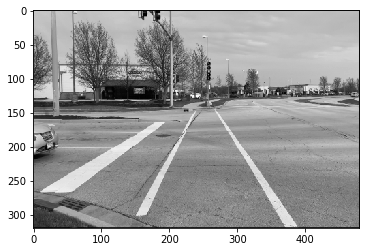

1. filtered image with white present.


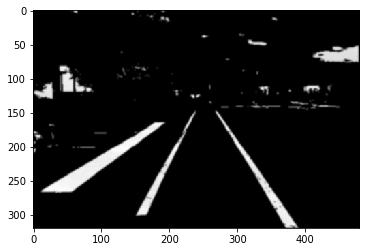

2. Canny Edge using openCV


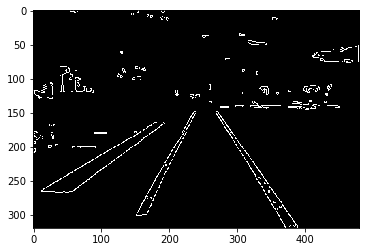

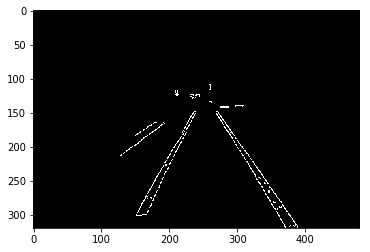

[[259 134 373 318]]
[[164 300 238 148]]


In [354]:
###main
#https://abhishek4273.com/2014/03/15/fast-roadpath-detection-using-opencv/
img_color = open_img_color('1038.png')
img = open_img('1038.png')
img = cv2.resize(img,(480,320))
img_color = cv2.resize(img_color,(480,320))
img_2 = open_img('stair_crosswalk_1.jpg')
img_3 = open_img('stair_crosswalk_2.jpg')
show_image_gray(img)
#show_image_gray(img_2)
#show_image_gray(img_3)
#img = do_erode(img,7)
#img = do_dilate(img,7)
#do filter 
print("1. filtered image with white present.")
img = filtered_white(img,200,255)
show_image_gray(img)
#img_2 = filtered_white(img_2,200,255)
#img_3 = filtered_white(img_3,200,255)

print("2. Canny Edge using openCV")
#canny_img = auto_canny(img)
canny_img = cv2.Canny(img,100,150)
#canny_img_2 = cv2.Canny(img_2,250,400)
#canny_img_3 = cv2.Canny(img_3,250,250)
#hough_transform(img,canny_img)
show_image_gray(canny_img)
#show_image_gray(canny_img_2)
#show_image_gray(canny_img_3)
img_roi = ROI(canny_img)
show_image_gray(img_roi)
rho = 4
theta = np.pi/180
#threshold is minimum number of intersections in a grid for candidate line to go to output
threshold = 30
min_line_len = 50
max_line_gap = 50
#my hough values started closer to the values in the quiz, but got bumped up considerably for the challenge video

line_image = hough_lines(img_color,img_roi, rho, theta, threshold, min_line_len, max_line_gap)

In [355]:
print('cv2 finished')

cv2 finished


In [356]:

cap = cv2.VideoCapture('IMG_1038.MOV')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 20.0, (480,320))
while(cap.isOpened()):
    ret, frame = cap.read()
   # print(frame.shape)
    #print(frame.type)
    #color = open_img_color(frame)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(gray,(480,320))
    color = cv2.resize(frame,(480,320))
    img = filtered_white(img,200,255)
    
    canny_img = cv2.Canny(img,100,150)
    img_roi = ROI(canny_img)
    rho = 4
    theta = np.pi/180
    #threshold is minimum number of intersections in a grid for candidate line to go to output
    threshold = 30
    min_line_len = 50
    max_line_gap = 100
    #my hough values started closer to the values in the quiz, but got bumped up considerably for the challenge video

    combo_img = hough_lines(color,img_roi, rho, theta, threshold, min_line_len, max_line_gap)
    out.write(combo_img)
    #cv2.imshow('frame',color)
    #if cv2.waitKey(1) & 0xFF == ord('q'):
        #break
out.release()
cap.release()
cv2.destroyAllWindows()

[[203 117 293 279]]
[[ 70 312 127 241]]
[[206 119 284 239]]
[[204 120 288 266]]
[[218 143 270  84]]
[[203 116 285 237]]
[[276 225 282 317]]
[[203 118 294 276]]
[[219 114 293 114]]
[[ 71 312 118 251]]
[[204 120 276 240]]
[[207 118 284 236]]
[[ 67 318 117 258]]
[[ 78 311 117 259]]
[[ 67 318 120 250]]
[[203 116 274 239]]
[[203 115 293 276]]
[[ 69 313 126 237]]
[[205 117 272 237]]
[[ 67 316 125 236]]
[[203 113 268 229]]
[[204 111 285 236]]
[[ 67 319 132 229]]
[[205 113 285 236]]
[[ 66 317 118 247]]
[[ 73 306 121 248]]
[[206 112 286 235]]
[[ 67 318 129 236]]
[[ 65 315 128 234]]
[[205 111 296 274]]
[[ 69 313 119 247]]
[[205 111 287 233]]
[[206 110 286 229]]
[[ 71 318 122 245]]
[[ 69 313 130 232]]
[[206 114 288 231]]
[[207 113 291 260]]
[[213 116 289 233]]
[[ 64 318 132 224]]
[[211 117 296 271]]
[[209 108 289 232]]
[[ 72 313 126 230]]
[[221 134 269  79]]
[[ 69 316 123 244]]
[[207 109 300 271]]
[[209 109 289 228]]
[[224 128 299 274]]
[[ 65 317 128 230]]
[[212 108 315 278]]
[[ 64 319 126 234]]


[[214 115 351 319]]
[[ 78 288 216  98]]
[[ 68 318 217  97]]
[[214 113 327 318]]
[[216 120 339 303]]
[[126 224 192 140]]
[[216 120 337 307]]
[[ 96 257 179 157]]
[[ 72 314 247  55]]
[[219 124 345 319]]
[[111 257 217  94]]
[[217 121 280 244]]
[[121 230 216 109]]
[[214 115 299 281]]
[[215 115 319 319]]
[[ 50 318 217 104]]
[[219 123 278 218]]
[[ 74 314 247  58]]
[[ 85 295 245  58]]
[[221 124 337 318]]
[[218 119 338 319]]
[[132 236 251  60]]
[[219 116 332 313]]
[[219 119 315 315]]
[[ 57 319 195 143]]
[[132 223 197 143]]
[[222 128 295 246]]
[[ 59 318 225 105]]
[[225 127 335 318]]
[[121 244 225 110]]
[[ 91 301 225  95]]
[[223 123 323 297]]
[[224 122 293 238]]
[[ 69 319 256  61]]
[[ 62 318 198 151]]
[[228 128 321 319]]
[[122 246 201 149]]
[[104 265 230 104]]
[[230 128 331 303]]
[[232 128 334 304]]
[[ 80 318 257  64]]
[[ 61 319 232 107]]
[[232 128 292 228]]
[[ 81 318 233 108]]
[[232 129 337 304]]
[[236 129 345 319]]
[[ 83 318 260  65]]
[[ 85 319 235 105]]
[[237 130 320 307]]
[[156 222 236 103]]


[[323 255 369 319]]
[[215  98 297 234]]
[[308 259 345 319]]
[[215  99 340 285]]
[[ 75 297 142 194]]
[[213 105 308 258]]
[[213 104 367 317]]
[[ 73 301 148 186]]
[[219 109 366 318]]
[[215 108 340 316]]
[[ 72 306 145 190]]
[[212 105 315 248]]
[[212 104 340 318]]
[[ 67 314 143 193]]
[[211 104 361 318]]
[[281 224 330 304]]
[[ 72 308 151 182]]
[[211 105 360 319]]
[[211 107 304 262]]
[[ 64 318 150 185]]
[[211 107 358 317]]
[[303 265 335 319]]
[[123 230 158 173]]
[[211 105 303 241]]
[[211 111 334 317]]
[[126 226 161 169]]
[[211 106 334 319]]
[[211 111 281 208]]
[[ 71 316 156 176]]
[[211 108 333 319]]
[[ 69 319 172 154]]
[[215 117 307 276]]
[[289 221 355 318]]
[[ 70 319 183 139]]
[[ 69 318 160 173]]
[[214 118 262 200]]
[[212 111 332 319]]
[[ 70 319 162 172]]
[[212 116 353 317]]
[[216 123 309 277]]
[[136 214 181 144]]
[[212 117 352 317]]
[[ 85 294 182 144]]
[[212 119 311 285]]
[[212 113 351 319]]
[[ 84 297 181 147]]
[[ 71 290 176 151]]
[[218 124 340 305]]
[[ 54 316 215 102]]
[[213 122 326 318]]


[[221 135 276 205]]
[[224 131 366 319]]
[[222 137 345 319]]
[[ 84 319 230  86]]
[[224 133 345 319]]
[[ 86 313 127 246]]
[[201 115 366 319]]
[[ 87 311 131 239]]
[[219 136 351 299]]
[[116 285 169 190]]
[[222 127 326 294]]
[[101 315 154 218]]
[[220 137 361 317]]
[[ 80 319 250  58]]
[[219 137 361 319]]
[[220 136 322 292]]
[[107 300 165 191]]
[[ 80 318 227  92]]
[[200 118 319 265]]
[[220 131 347 305]]
[[217 139 336 315]]
[[ 83 317 122 252]]
[[222 143 336 319]]
[[ 87 313 156 198]]
[[219 140 275 214]]
[[220 133 334 290]]
[[263 185 327 185]]
[[217 140 337 318]]
[[138 249 164 196]]
[[218 140 357 318]]
[[ 83 318 220  90]]
[[220 141 324 280]]
[[ 99 315 163 199]]
[[199 123 315 262]]
[[214 139 309 275]]
[[ 80 318 155 198]]
[[216 138 304 247]]
[[ 81 317 224  87]]
[[216 138 349 303]]
[[ 79 319 224  87]]
[[220 140 340 318]]
[[216 138 361 317]]
[[ 79 319 155 198]]
[[215 138 360 317]]
[[130 251 198 119]]
[[219 138 359 317]]
[[ 99 316 161 199]]
[[215 139 361 319]]
[[218 139 339 319]]
[[ 79 318 225  93]]


/Users/xiaotengyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in int_scalars
  


[[234  80 361 319]]
[[255 156 372 317]]
[[255 144 357 315]]
[[306 235 371 232]]
[[228 128 365 316]]
[[258 205 258  96]]
[[254 145 358 318]]
[[255 118 360 316]]
[[105 260 257 128]]
[[257 206 257  87]]
[[216 123 368 317]]
[[257 207 257  80]]
[[254 148 362 315]]
[[313 238 375 238]]
[[215 122 363 319]]
[[256 163 256 109]]
[[253 145 361 319]]
[[256 205 256 100]]
[[253 144 366 312]]
[[258 170 258  67]]
[[223 126 366 316]]
[[256 166 256  85]]
[[245 154 368 317]]
[[252 140 356 319]]
[[252 151 373 318]]
[[129 312 256 116]]
[[252 162 254  56]]
[[308 243 379 244]]
[[253  97 355 317]]
[[107 319 263  69]]
[[323 242 369 316]]
[[247 125 354 318]]
[[252 124 364 318]]
[[106 319 180 201]]
[[322 243 367 318]]
[[249 160 256  60]]
[[252 165 253  66]]
[[248 155 357 318]]
[[219 125 360 319]]
[[251 165 253  70]]
[[221 125 371 317]]
[[246 122 365 319]]
[[ 87 274 289 122]]
[[252 166 260  72]]
[[245 154 364 318]]
[[252 148 371 318]]
[[255 208 255  57]]
[[328 251 353 313]]
[[255 169 256  86]]
[[258 207 258  64]]


error: OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'
